# Introduction

This notebook demonstrates how to optimize a PyTorch model for Continuous Ranked Probability Score (CRPS) using the TorchNaut library. In this "Bring Your Own Model" example, we'll use a simple feedforward neural network and train it to minimize the CRPS loss function. We'll be working with the unweighted CRPS loss. The notebook covers data loading, preprocessing, model definition, training loop, and evaluation, showcasing how TorchNaut simplifies the process of probabilistic forecasting with PyTorch.


# Imports, loading and splitting data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from torchnaut import crps, kde, utils
from torchnaut.utils import LabelScaler

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
data = load_diabetes()
X, y = data.data, data.target.reshape(-1, 1) # Note: reshape y to 2D.

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing

In [2]:
# Standardize features using training data only
scaler_X = StandardScaler().fit(X_train)
X_train = scaler_X.transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# The utils.LabelScaler class provides a convenient way to standardize targets, with the ability to
# also inverse transform tensors of shape [batch_size, n_samples, n_features]
scaler_y = LabelScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model and optimizer

In [3]:
# Define a simple neural network
class CRPSModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            # EpsilonSampler transforms [batch_size, 64] to [batch_size, n_samples, 64 + 16]
            # and fills the last 16 columns with samples from the standard normal distribution.
            crps.EpsilonSampler(16), 
            nn.Linear(64 + 16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        ])

    def forward(self, x, n_samples=100):
        with crps.EpsilonSampler.n_samples(n_samples): # Override the default number of n_samples.
            for layer in self.layers:
                x = layer(x)
        return x.squeeze() # [batch_size, n_samples, 1] -> [batch_size, n_samples]

# Initialize model and optimizer
model = CRPSModel(input_dim=X.shape[1]).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training

In [4]:
# Training loop with validation
epochs = 100
best_val_loss = np.inf
best_model = None
patience = 0
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        # CRPS loss returns a tensor of shape [batch_size, n_samples] which needs to be reduced
        # to a scalar.
        loss = crps.crps_loss(outputs, batch_y).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            outputs_scaled = scaler_y.inverse_transform(outputs.unsqueeze(-1)).squeeze()
            loss = crps.crps_loss(outputs_scaled, batch_y)
            val_losses.append(loss.cpu().numpy())
        val_loss = np.concatenate(val_losses).mean()
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val CRPS: {val_loss:.4f}")
    if best_val_loss > val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        patience = 0
    else:
        patience += 1
        if patience >= 9:
            print("Early stopping!")
            model.load_state_dict(best_model)
            break

Epoch [1/100], Train Loss: 0.7287, Val CRPS: 37.6634
Epoch [2/100], Train Loss: 0.5286, Val CRPS: 28.5402
Epoch [3/100], Train Loss: 0.4364, Val CRPS: 26.2443
Epoch [4/100], Train Loss: 0.4071, Val CRPS: 25.3673
Epoch [5/100], Train Loss: 0.3932, Val CRPS: 26.2733
Epoch [6/100], Train Loss: 0.3861, Val CRPS: 26.1491
Epoch [7/100], Train Loss: 0.3726, Val CRPS: 26.8647
Epoch [8/100], Train Loss: 0.3792, Val CRPS: 27.3422
Epoch [9/100], Train Loss: 0.3683, Val CRPS: 27.0587
Epoch [10/100], Train Loss: 0.3646, Val CRPS: 27.7567
Epoch [11/100], Train Loss: 0.3693, Val CRPS: 27.6810
Epoch [12/100], Train Loss: 0.3673, Val CRPS: 27.5384
Epoch [13/100], Train Loss: 0.3645, Val CRPS: 27.3271
Early stopping!


# Testing

In [5]:
# Marginal estimates are predictions that are unconditional on the input.
# For regression, the marginal point prediction is the mean of the training targets, essentially
# resulting in the RMSE estimating the standard deviation of the target distribution. Analogously,
# the marginal distribution is a constant distribution, which provides a useful reference point
# for interpreting CRPS/NLL scores.
marginal_point_pred = X_train_tensor.mean()
marginal_dist_pred = torch.tensor(y_train).T.to(device)

model.eval()
test_crps = []
test_rmse = []
test_nll = []
marginal_crps = []
marginal_nll = []
all_outputs = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        outputs_scaled = scaler_y.inverse_transform(outputs.unsqueeze(-1)).squeeze()
        loss = crps.crps_loss(outputs_scaled, batch_y)
        test_crps.append(loss.cpu().numpy())
        test_rmse.append(((outputs_scaled.mean(axis=-1) - batch_y.squeeze()) ** 2).cpu().numpy())
        marginal_loss = crps.crps_loss(marginal_dist_pred.repeat(batch_y.shape[0], 1), batch_y).cpu()
        marginal_crps.append(marginal_loss)

        # Calculate NLLs using KDE
        # The kde.nll_gpu() function works in a gpu accelerated manner as long as you use "with torch.device():"
        # Unlike kde.get_kde() (used for plotting below), it is optimized for efficiently returning the NLL
        # values for a single ground-truth point per predicted distribution (the values in batch_y)
        with torch.device(outputs.device):
            nll = kde.nll_gpu(outputs_scaled, batch_y)
            test_nll.append(nll.cpu().numpy())
            mnll = kde.nll_gpu(marginal_dist_pred.repeat(batch_y.shape[0], 1), batch_y)
            marginal_nll.append(mnll.cpu().numpy())

        # Save all outputs for calibration plotting later
        all_outputs.append(outputs_scaled.cpu().numpy())

    test_crps = np.concatenate(test_crps).mean()
    test_nll = np.concatenate(test_nll).mean()
    test_rmse = np.sqrt(np.concatenate(test_rmse).mean())
    test_crps_marginal = np.concatenate(marginal_crps).mean()
    test_nll_marginal = np.concatenate(marginal_nll).mean()
    all_outputs = np.concatenate(all_outputs, axis=0)

print(f"Test CRPS: {test_crps:.4f} (marginal: {test_crps_marginal:.4f})")
print(f"Test NLL: {test_nll:.4f} (marginal: {test_nll_marginal:.4f})")
print(f"Test RMSE: {test_rmse:.4f} (marginal: {((y_test_tensor-marginal_point_pred)**2).mean()**(1/2):.4f})")

Test CRPS: 30.4446 (marginal: 43.0078)
Test NLL: 5.3558 (marginal: 5.6368)
Test RMSE: 54.8374 (marginal: 166.5705)


# Plotting example distributions

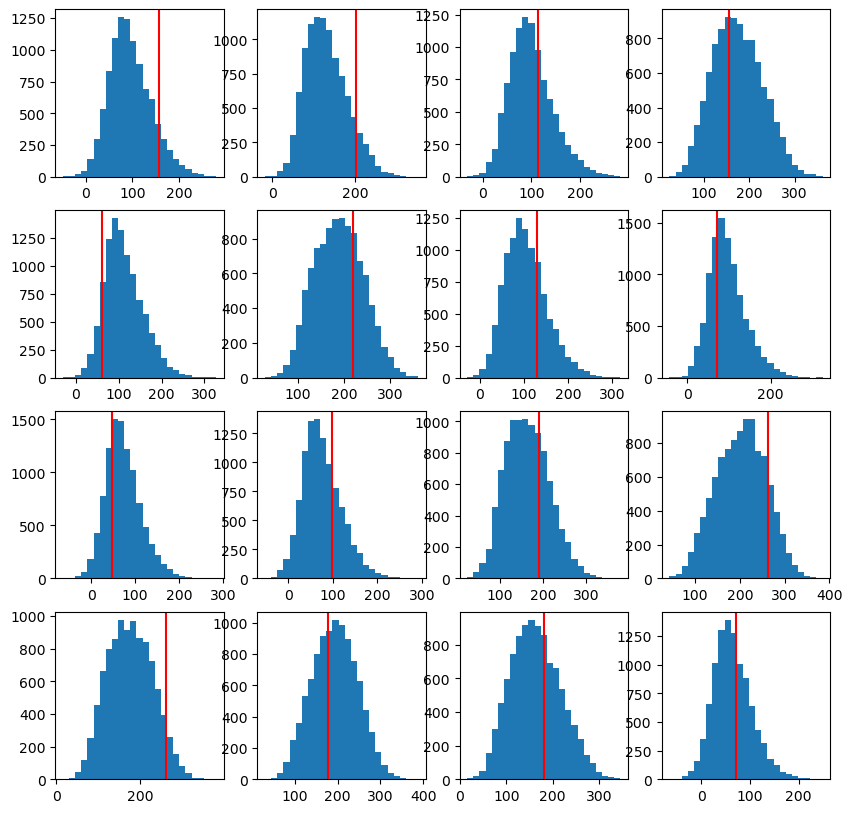

In [6]:
# Predictions for the first batch of the test set
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X, n_samples=10000).cpu()
        outputs_scaled = scaler_y.inverse_transform(outputs.unsqueeze(-1)).squeeze()
        break

fig, _ = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, (preds, y) in enumerate(zip(outputs_scaled, batch_y)):
    plt.subplot(4, 4, i+1)
    plt.hist(preds.cpu().numpy(), bins=25)
    plt.axvline(y, color="red")

## Plotting kernel density estimates

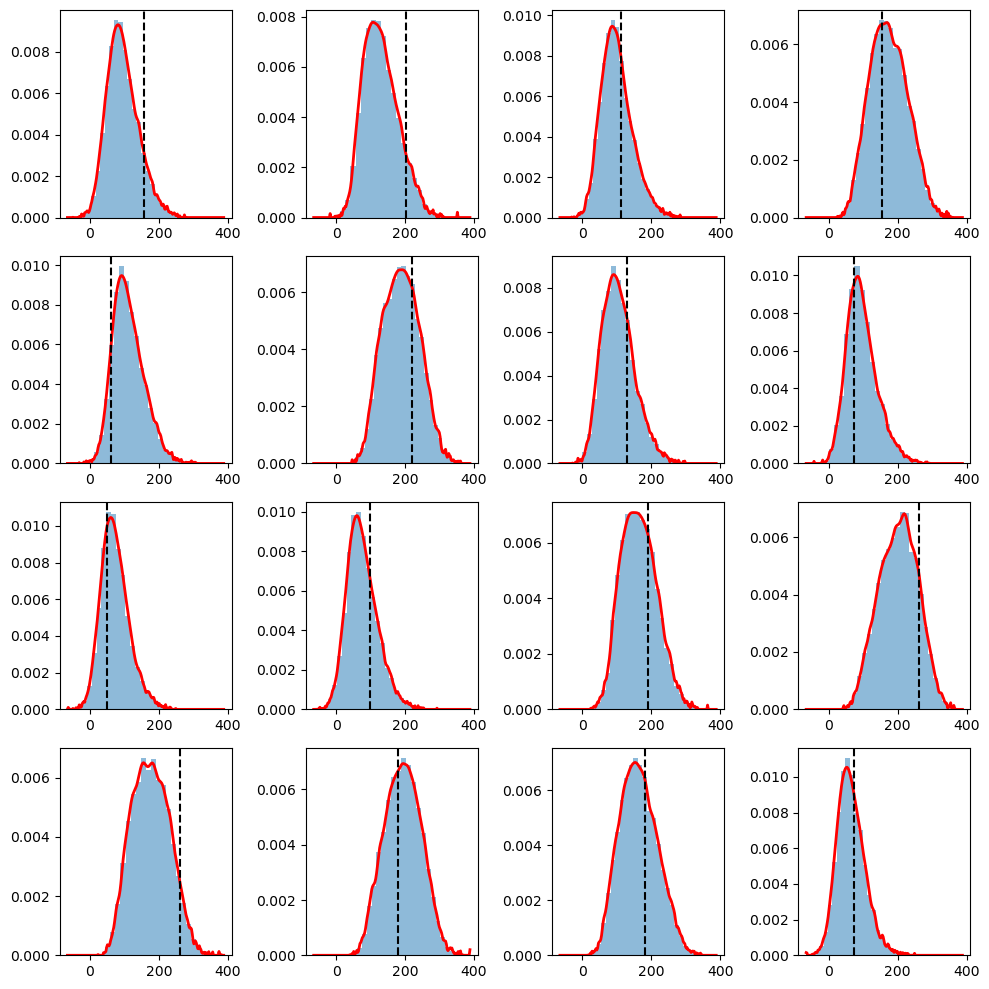

In [7]:
# Get KDE distributions. Returns a list of PyTorch MixtureSameFamily distributions.
kde_dists = kde.get_kde(outputs_scaled)

# Create evaluation points for density plotting
x_range = np.linspace(outputs_scaled.min().item(), outputs_scaled.max().item(), 200)
x_eval = torch.tensor(x_range).float()

fig, _ = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, (preds, y, dist) in enumerate(zip(outputs_scaled, batch_y, kde_dists)):
    plt.subplot(4, 4, i+1)
    # Plot histogram of samples
    plt.hist(preds.cpu().numpy(), bins=25, density=True, alpha=0.5)
    # Plot KDE
    density = torch.exp(dist.log_prob(x_eval))
    plt.plot(x_range, density.cpu().numpy(), 'r-', lw=2)
    plt.axvline(y, color="black", linestyle='--')
plt.tight_layout()

# Plotting calibration curve

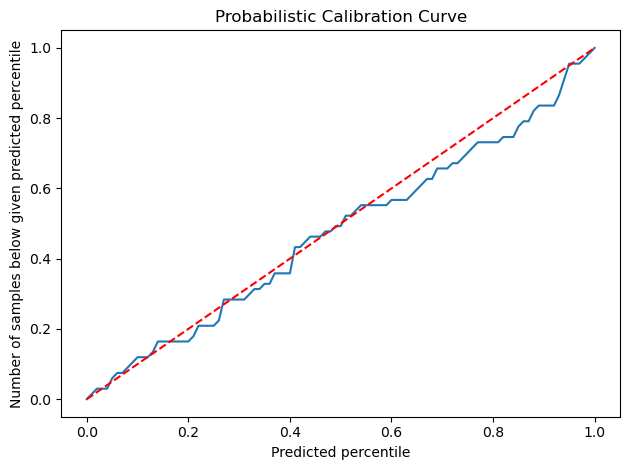

In [8]:
ref_percentiles, cumulative_percentiles = utils.calculate_pit_cdf(all_outputs, y_test)

# Plot probabilistic calibration curve (PIT CDF) against the reference line
plt.title("Probabilistic Calibration Curve")
plt.plot(ref_percentiles, cumulative_percentiles)
plt.plot(ref_percentiles, ref_percentiles, c="r", linestyle='--')
plt.ylabel("Number of samples below given predicted percentile")
plt.xlabel("Predicted percentile")
plt.tight_layout()